In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from obspy.core import UTCDateTime
from obspy.core.stream import Stream
from SeismicData import SeismicData

In [88]:
#root_folder = "data20180703ext"
#root_folder = "data20180703"
root_folder = "data20180505"
ud01_data_folder_path = root_folder+"/UD01"
ud02_data_folder_path = root_folder+"/UD02"
ud03_data_folder_path = root_folder+"/UD03"
ud04_data_folder_path = root_folder+"/UD04"

directions_data_folders = ["6d97e2", "6d97n2", "6d97z2"]

In [ ]:
def union_close_times(times):
    united_times = []
    for i in range(len(times)):
        if times[i].minute - times[i-1].minute < 1:
            continue
        else:
            united_times.append(times[i])
    
    return united_times

In [89]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [90]:
def square_sum (seismic_data):
    square_sum = list()
    for i, time in enumerate(seismic_data.times):
        summ = np.float64(0)
        for trace in seismic_data.traces:
            summ+=trace[i]*trace[i]
        summ /= seismic_data.alive_traces_count[i]
        square_sum.append((time, summ))
    return square_sum


In [91]:
def plot(x, y):    
    from matplotlib import pyplot as plt
    plt.figure(figsize=(30,10))
    plt.plot(x,y)
    plt.show()

In [92]:
def process_station_data(station_data_folder):
    import os 
    station_data = Stream()
    for direction in directions_data_folders:
        direction_stream = Stream()
        data_folder = station_data_folder+"/"+direction
        for filename in os.listdir(data_folder):
            input_stream=read(data_folder+"/"+filename)
            direction_stream += input_stream
        direction_stream.merge(fill_value=0)
        station_data+=direction_stream
    return station_data

In [107]:
%%time
station_data = process_station_data(ud01_data_folder_path)
station_data += process_station_data(ud02_data_folder_path)
station_data += process_station_data(ud03_data_folder_path)
station_data += process_station_data(ud04_data_folder_path)

Wall time: 15.3 s


In [108]:
min_filtering_frequency = 2
max_filtering_frequency = 6
station_data = station_data.detrend()
station_data = station_data.filter("bandpass", freqmin=min_filtering_frequency,freqmax = max_filtering_frequency)

C:\ProgramData\Anaconda3\lib\site-packages\obspy\signal\detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


In [9]:
%%time
seismic_data = SeismicData(station_data)

Station data preprocessing...
max trace = .6D97..HHE | 2018-05-05T05:00:00.000000Z - 2018-05-05T23:59:59.990000Z | 100.0 Hz, 6840000 samples
max trace times = [UTCDateTime(2018, 5, 5, 5, 0) UTCDateTime(2018, 5, 5, 5, 0, 0, 10000)
 UTCDateTime(2018, 5, 5, 5, 0, 0, 20000) ...
 UTCDateTime(2018, 5, 5, 23, 59, 59, 970000)
 UTCDateTime(2018, 5, 5, 23, 59, 59, 980000)
 UTCDateTime(2018, 5, 5, 23, 59, 59, 990000)]
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessi

In [10]:
%%time
squareSum = square_sum(seismic_data)

Wall time: 1min 30s


In [11]:
x = list()
y = list()

for item in squareSum:
    x.append(item[0])
    y.append(item[1])


In [12]:
m=2250

In [13]:
y_av = moving_average(y.copy(), m)

In [14]:
x_av = x[:len(y_av)]

In [15]:
plot(x_av, y_av)

<Figure size 3000x1000 with 1 Axes>

In [15]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(y_av, height=0.08e8)
print('len peaks = {}'.format(len(peaks)))

len peaks = 9


In [16]:
lpeaks = np.asarray(peaks)
x_av = np.asarray(x_av)

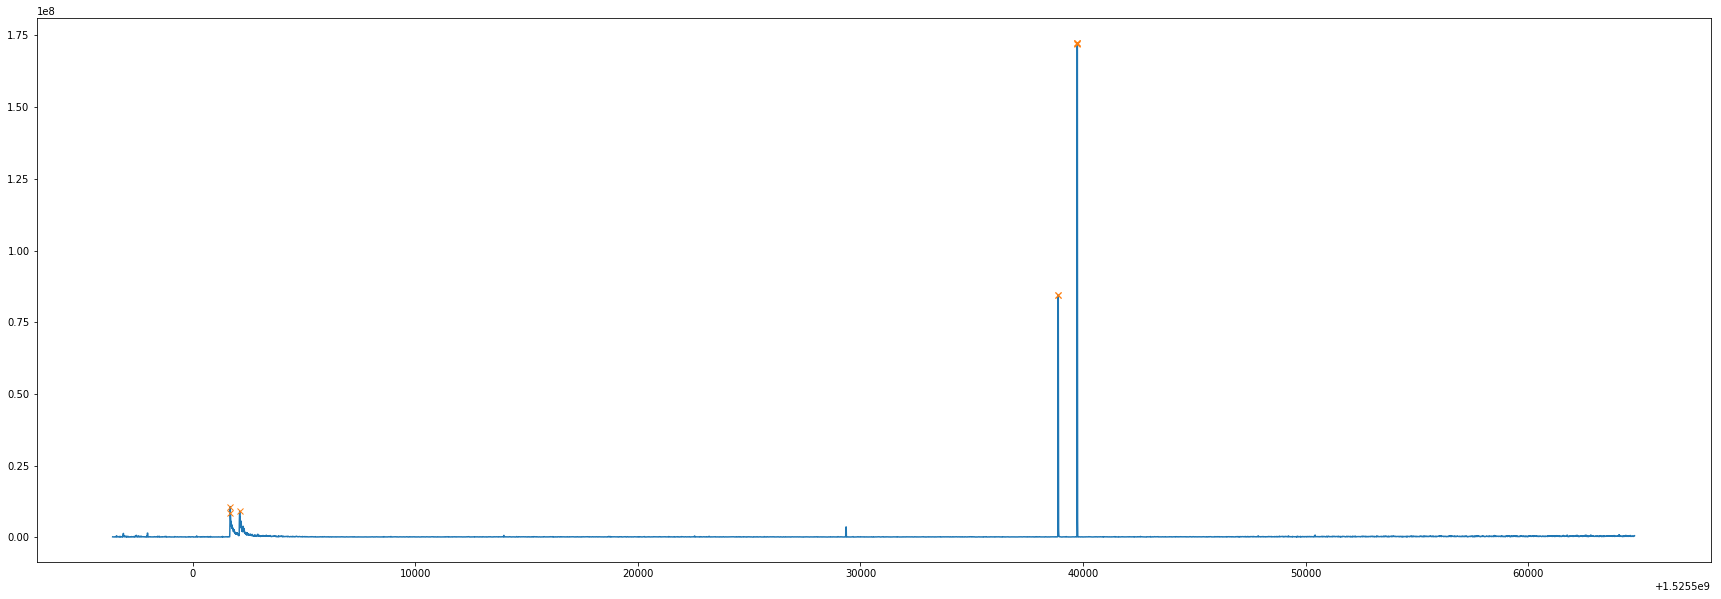

In [18]:
from matplotlib import pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(x_av,y_av)
plt.plot(x_av[lpeaks], y_av[lpeaks], "x")
plt.show()

In [49]:
peaks_times

array([UTCDateTime(2018, 5, 5, 6, 28, 4, 390000),
       UTCDateTime(2018, 5, 5, 6, 28, 9, 420000),
       UTCDateTime(2018, 5, 5, 6, 35, 8, 290000),
       UTCDateTime(2018, 5, 5, 16, 48, 6, 910000),
       UTCDateTime(2018, 5, 5, 16, 48, 7, 130000),
       UTCDateTime(2018, 5, 5, 17, 2, 22, 790000),
       UTCDateTime(2018, 5, 5, 17, 2, 22, 850000),
       UTCDateTime(2018, 5, 5, 17, 2, 23, 120000),
       UTCDateTime(2018, 5, 5, 17, 2, 24, 450000)], dtype=object)

In [59]:
filtered_times = union_close_times(peaks_times)
filtered_times.append(peaks_times[len(peaks_times)-1])
filtered_times

[2018-05-05T06:28:04.390000Z,
 2018-05-05T06:35:08.290000Z,
 2018-05-05T16:48:06.910000Z,
 2018-05-05T17:02:24.450000Z]

In [113]:
times = station_data[0].times("utcdatetime")
peaks_times = times[lpeaks]
filtered_times = union_close_times(peaks_times)
filtered_times.append(peaks_times[len(peaks_times)-1])
print(filtered_times)



[2018-05-05T06:28:04.390000Z,
 2018-05-05T06:35:08.290000Z,
 2018-05-05T16:48:06.910000Z,
 2018-05-05T17:02:24.450000Z]

In [115]:
for i in range(len(filtered_times)):
    f_time = filtered_times[i]
    ind = np.where(times==f_time)[0][0]
    print('ind: {0}'.format(ind))
    startInd = ind - 1500
    endInd = ind + 3000
    copy = station_data.copy()
    trimed = copy.trim(starttime=times[startInd], endtime=times[endInd])
    print('trimed: {0}'.format(trimed))
    trimed.write("test{0}.msd".format(ind), format="MSEED")


ind: 528439
trimed: 12 Trace(s) in Stream:
.6D97..HHE | 2018-05-05T06:27:49.390000Z - 2018-05-05T06:28:34.390000Z | 100.0 Hz, 4501 samples
.6D97..HHN | 2018-05-05T06:27:49.390000Z - 2018-05-05T06:28:34.390000Z | 100.0 Hz, 4501 samples
.6D97..HHZ | 2018-05-05T06:27:49.390000Z - 2018-05-05T06:28:34.390000Z | 100.0 Hz, 4501 samples
.6D98..HHE | 2018-05-05T06:27:49.390000Z - 2018-05-05T06:28:34.390000Z | 100.0 Hz, 4501 samples
.6D98..HHN | 2018-05-05T06:27:49.390000Z - 2018-05-05T06:28:34.390000Z | 100.0 Hz, 4501 samples
.6D98..HHZ | 2018-05-05T06:27:49.390000Z - 2018-05-05T06:28:34.390000Z | 100.0 Hz, 4501 samples
.6E02..HHE | 2018-05-05T06:27:49.390000Z - 2018-05-05T06:28:34.390000Z | 100.0 Hz, 4501 samples
.6E02..HHN | 2018-05-05T06:27:49.390000Z - 2018-05-05T06:28:34.390000Z | 100.0 Hz, 4501 samples
.6E02..HHZ | 2018-05-05T06:27:49.390000Z - 2018-05-05T06:28:34.390000Z | 100.0 Hz, 4501 samples
.6E09..HHE | 2018-05-05T06:27:49.390000Z - 2018-05-05T06:28:34.390000Z | 100.0 Hz, 4501 sampl

C:\ProgramData\Anaconda3\lib\site-packages\obspy\io\mseed\core.py:772: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


ind: 570829
trimed: 12 Trace(s) in Stream:
.6D97..HHE | 2018-05-05T06:34:53.290000Z - 2018-05-05T06:35:38.290000Z | 100.0 Hz, 4501 samples
.6D97..HHN | 2018-05-05T06:34:53.290000Z - 2018-05-05T06:35:38.290000Z | 100.0 Hz, 4501 samples
.6D97..HHZ | 2018-05-05T06:34:53.290000Z - 2018-05-05T06:35:38.290000Z | 100.0 Hz, 4501 samples
.6D98..HHE | 2018-05-05T06:34:53.290000Z - 2018-05-05T06:35:38.290000Z | 100.0 Hz, 4501 samples
.6D98..HHN | 2018-05-05T06:34:53.290000Z - 2018-05-05T06:35:38.290000Z | 100.0 Hz, 4501 samples
.6D98..HHZ | 2018-05-05T06:34:53.290000Z - 2018-05-05T06:35:38.290000Z | 100.0 Hz, 4501 samples
.6E02..HHE | 2018-05-05T06:34:53.290000Z - 2018-05-05T06:35:38.290000Z | 100.0 Hz, 4501 samples
.6E02..HHN | 2018-05-05T06:34:53.290000Z - 2018-05-05T06:35:38.290000Z | 100.0 Hz, 4501 samples
.6E02..HHZ | 2018-05-05T06:34:53.290000Z - 2018-05-05T06:35:38.290000Z | 100.0 Hz, 4501 samples
.6E09..HHE | 2018-05-05T06:34:53.290000Z - 2018-05-05T06:35:38.290000Z | 100.0 Hz, 4501 sampl

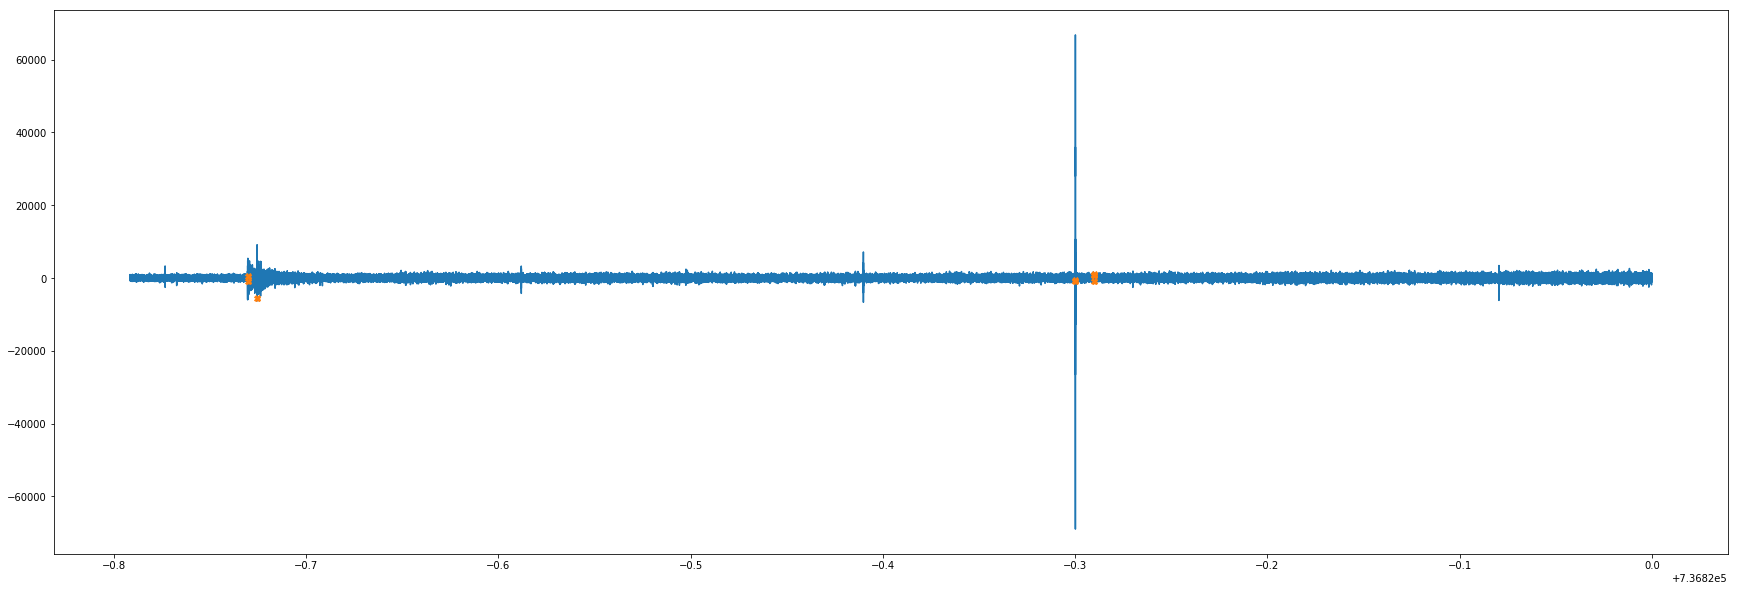

In [74]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1)
ax.plot(times, t.data)
ax.plot(times[lpeaks], t.data[lpeaks], "X")
plt.show()

In [19]:
%%time
t1 = station_data[0]
t1_data = t1.data
t1_times = t1.times("utcdatetime")
starttime=UTCDateTime('2018-05-05T16:48:05')
endtime=UTCDateTime('2018-05-05T16:48:30')
ind_s = np.where(t1_times > starttime)
ind_e = np.where(t1_times < endtime)
indexes = np.intersect1d(ind_s, ind_e)
t1_matplotlib_times = t1.times("matplotlib")

inter = np.intersect1d(lpeaks, indexes)

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1)
ax.plot(t1_matplotlib_times[indexes], t1_data[indexes])
ax.plot(t1_matplotlib_times[inter], t1_data[inter], "X")
plt.show()

TypeError: 'module' object is not callable

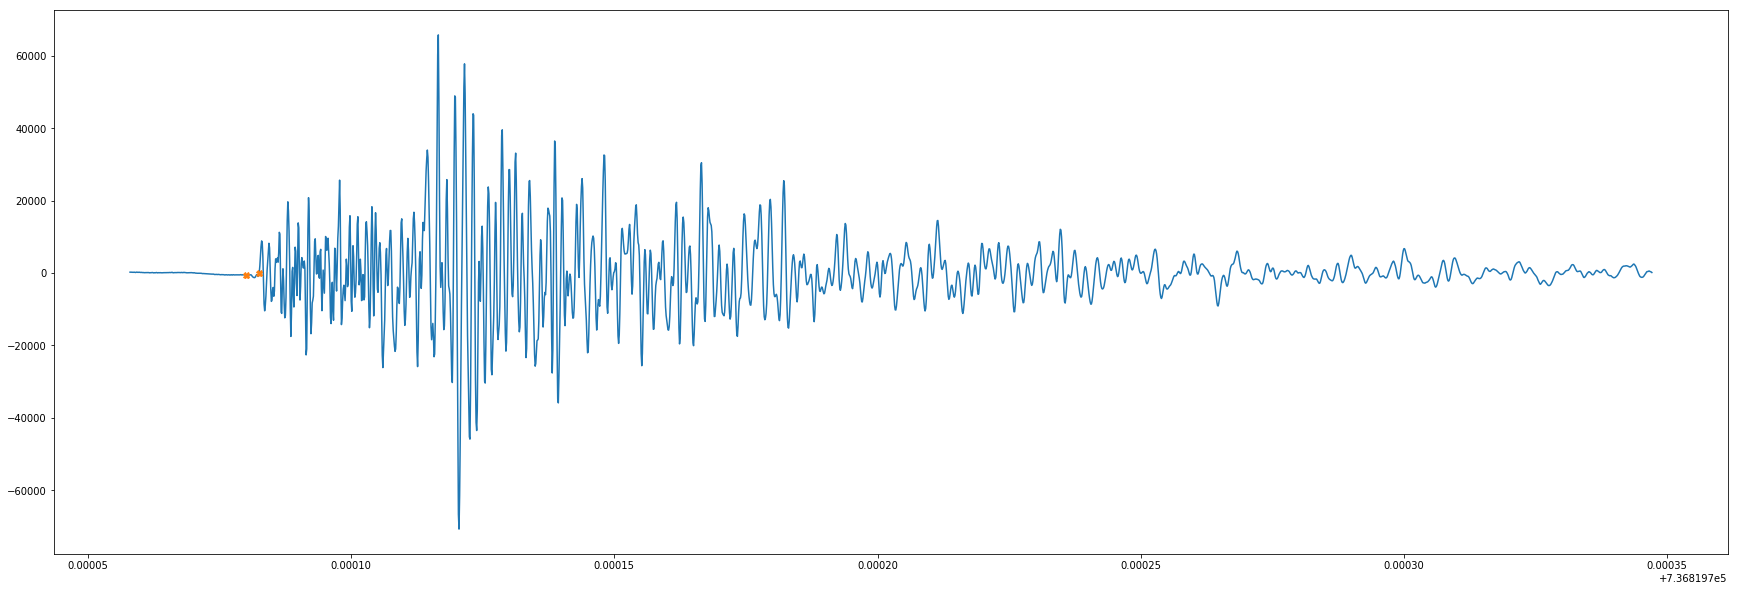

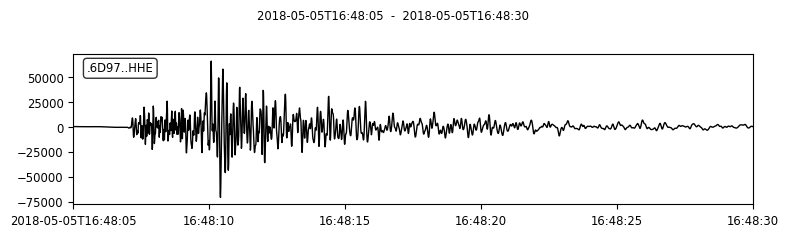

In [139]:
station_data[0].plot(equal_scale=False, starttime=UTCDateTime('2018-05-05T16:48:05'), endtime=UTCDateTime('2018-05-05T16:48:30'))

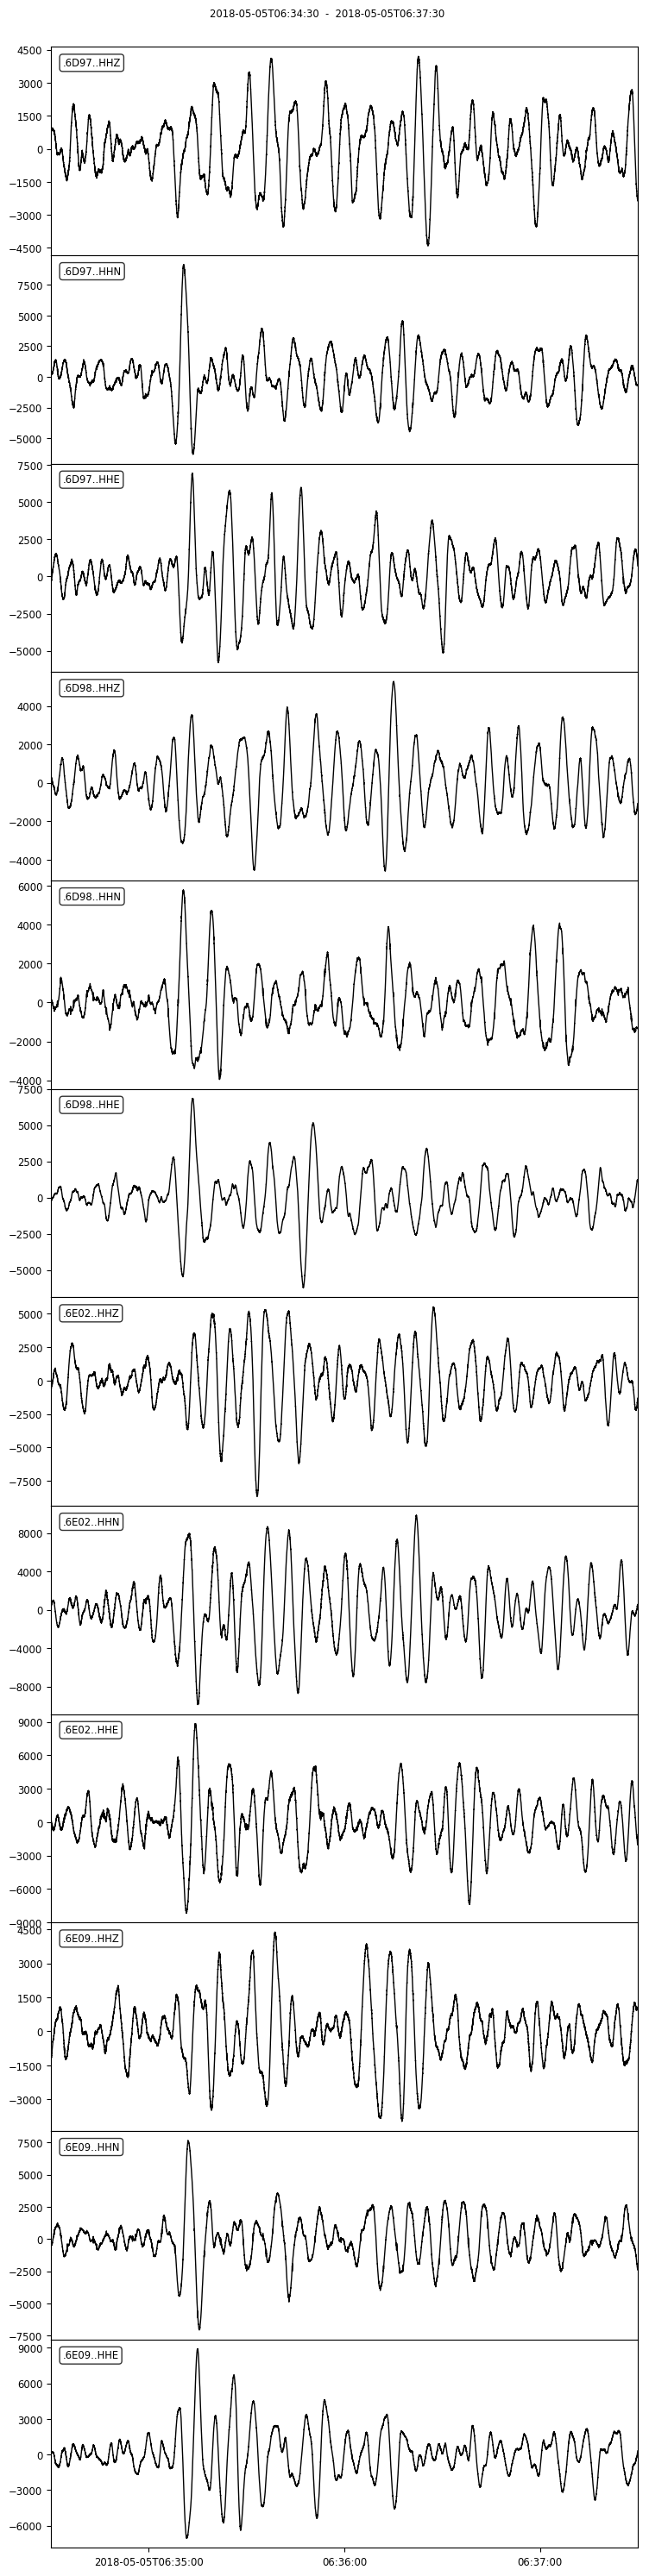

In [147]:
station_data.plot(equal_scale=False, starttime=UTCDateTime('2018-05-05T06:34:30'), endtime=UTCDateTime('2018-05-05T06:37:30'))

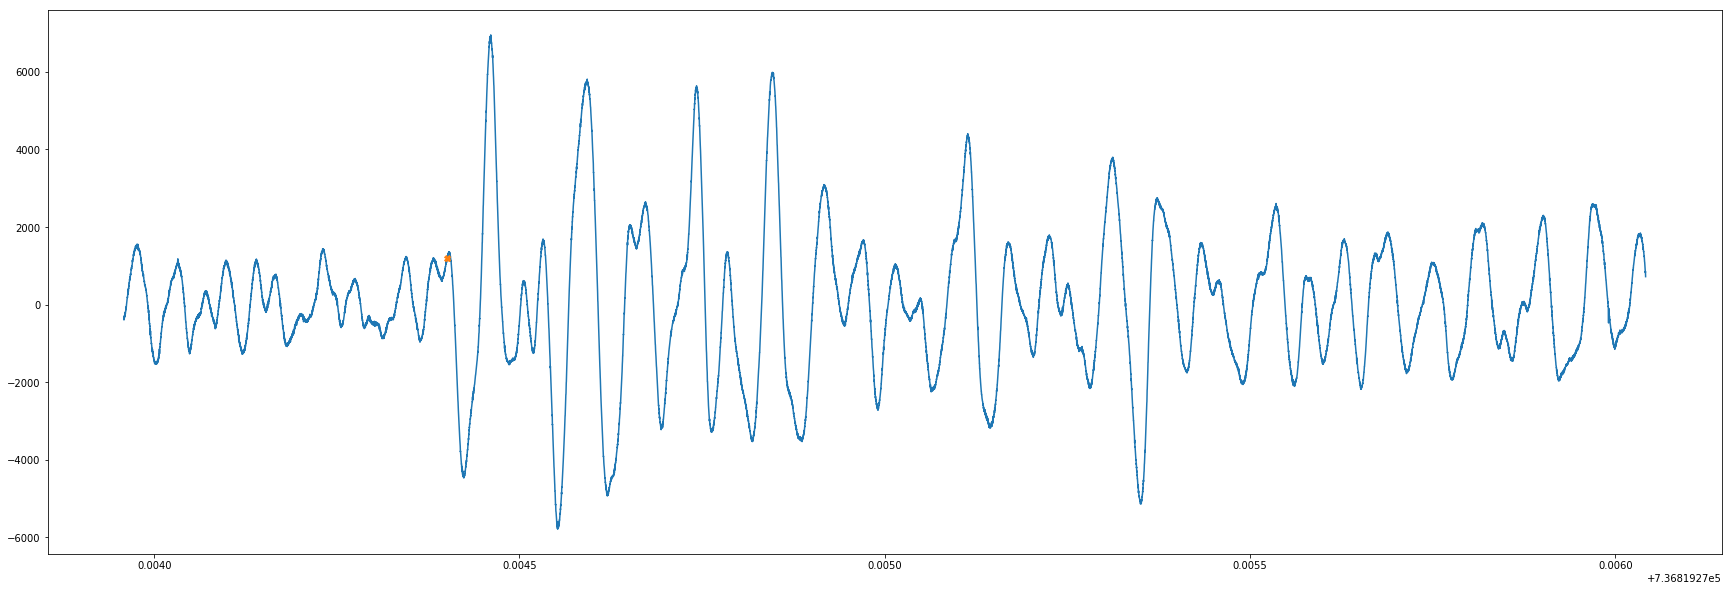

In [148]:
t1 = station_data[0]
t1_data = t1.data
t1_times = t1.times("utcdatetime")
starttime=UTCDateTime('2018-05-05T06:34:30')
endtime=UTCDateTime('2018-05-05T06:37:30')
ind_s = np.where(t1_times > starttime)
ind_e = np.where(t1_times < endtime)
indexes = np.intersect1d(ind_s, ind_e)
t1_matplotlib_times = t1.times("matplotlib")

inter = np.intersect1d(lpeaks, indexes)

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1)
ax.plot(t1_matplotlib_times[indexes], t1_data[indexes])
ax.plot(t1_matplotlib_times[inter], t1_data[inter], "X")
plt.show()

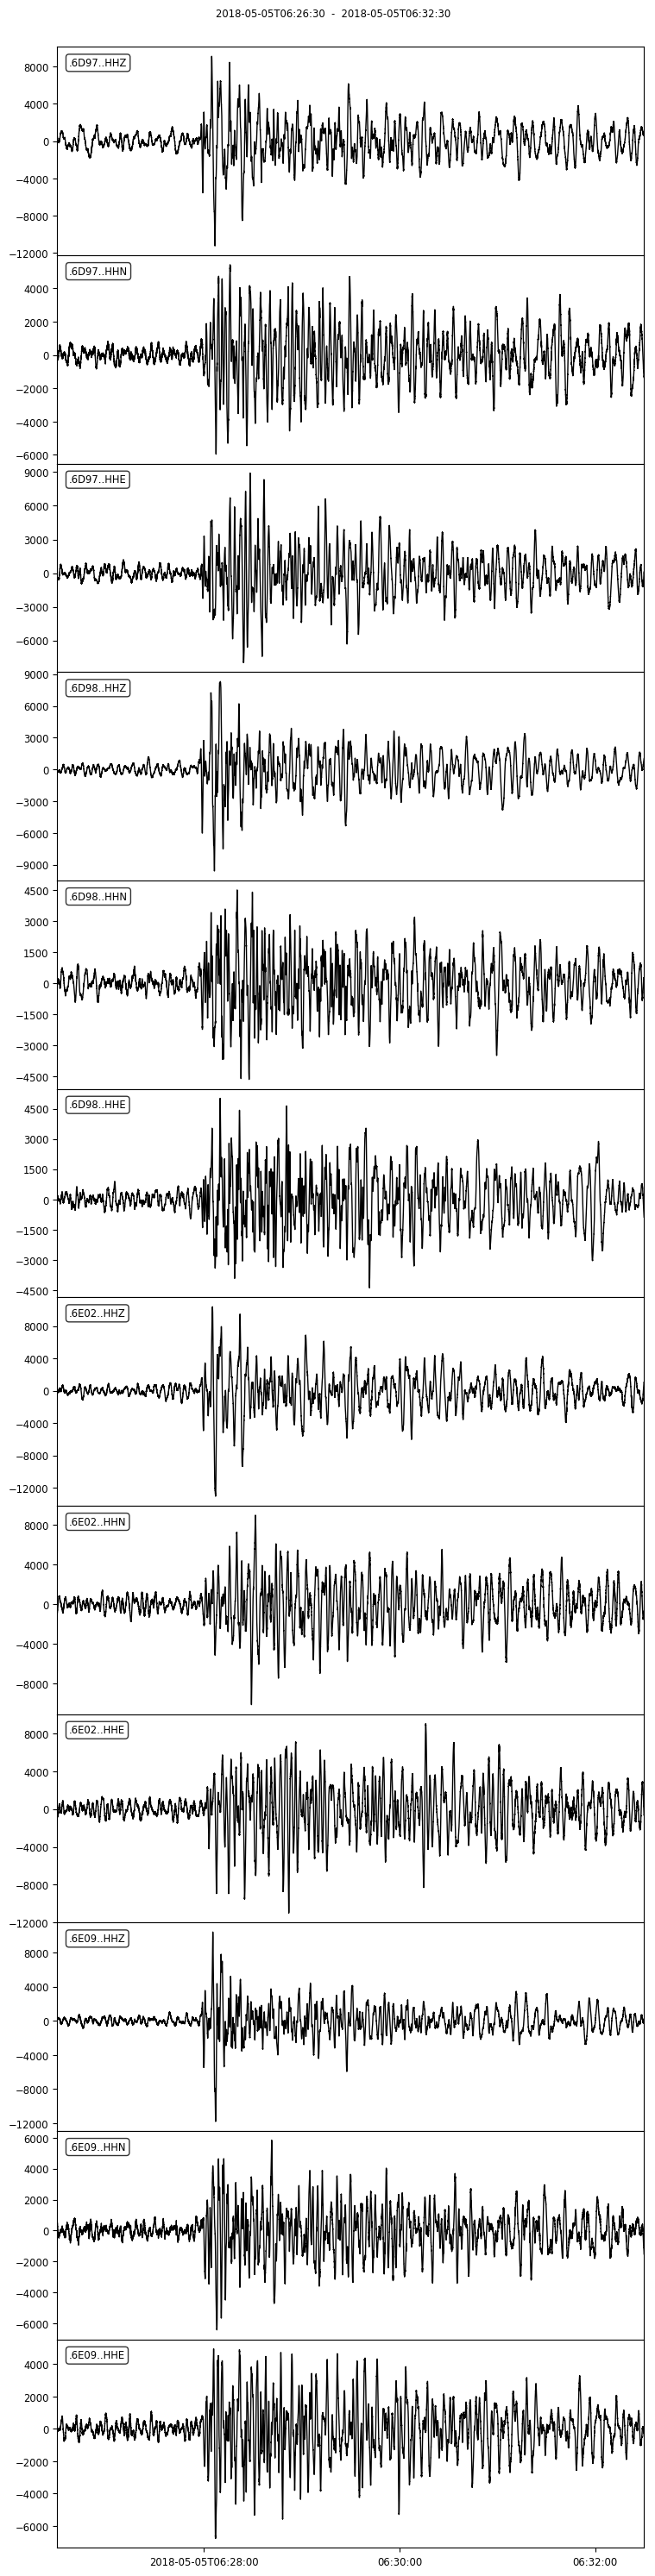

In [152]:
station_data.plot(equal_scale=False, starttime=UTCDateTime('2018-05-05T06:26:30'), endtime=UTCDateTime('2018-05-05T06:32:30'))

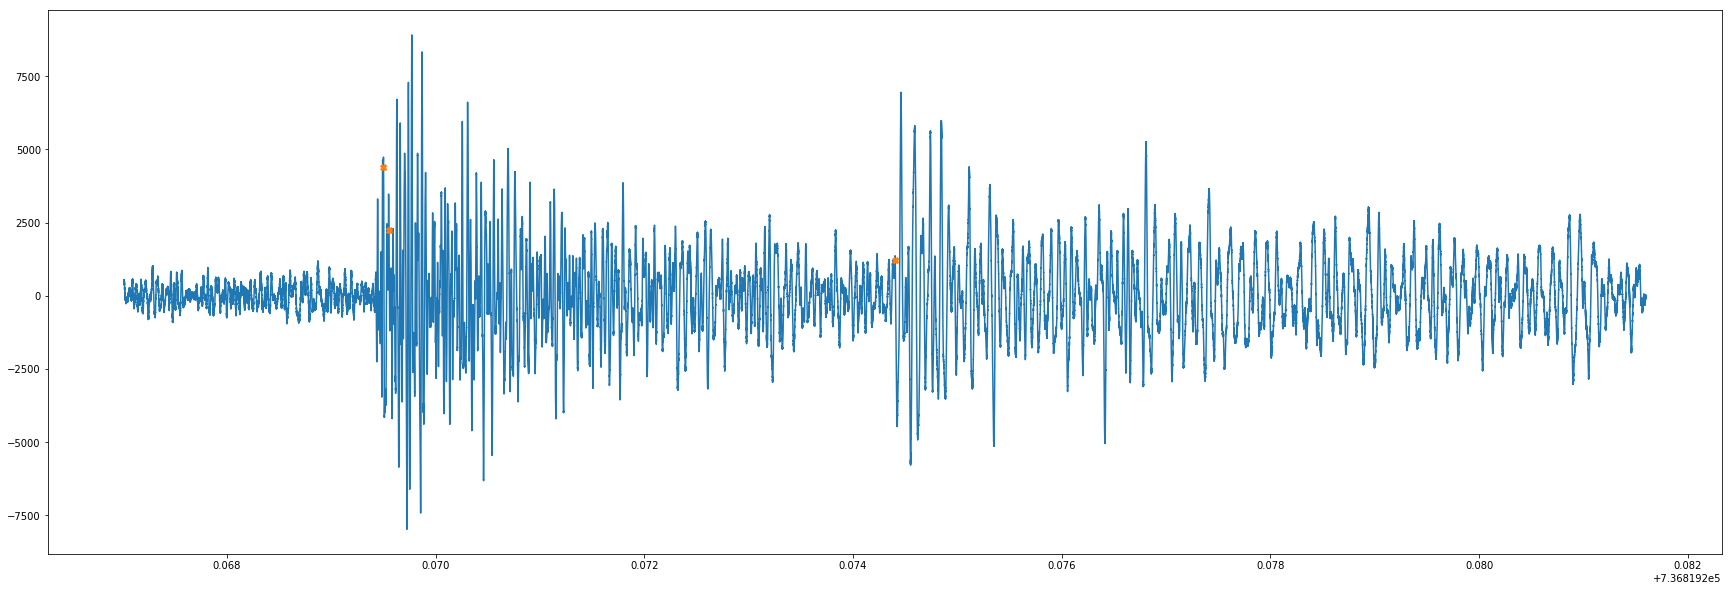

In [20]:
%%time
t1 = station_data[0]
t1_data = t1.data
t1_times = t1.times("utcdatetime")
starttime=UTCDateTime('2018-05-05T06:24:30')
endtime=UTCDateTime('2018-05-05T06:45:30')
ind_s = np.where(t1_times > starttime)
ind_e = np.where(t1_times < endtime)
indexes = np.intersect1d(ind_s, ind_e)
t1_matplotlib_times = t1.times("matplotlib")

inter = np.intersect1d(lpeaks, indexes)

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1)
ax.plot(t1_matplotlib_times[indexes], t1_data[indexes])
ax.plot(t1_matplotlib_times[inter], t1_data[inter], "X")
plt.show()

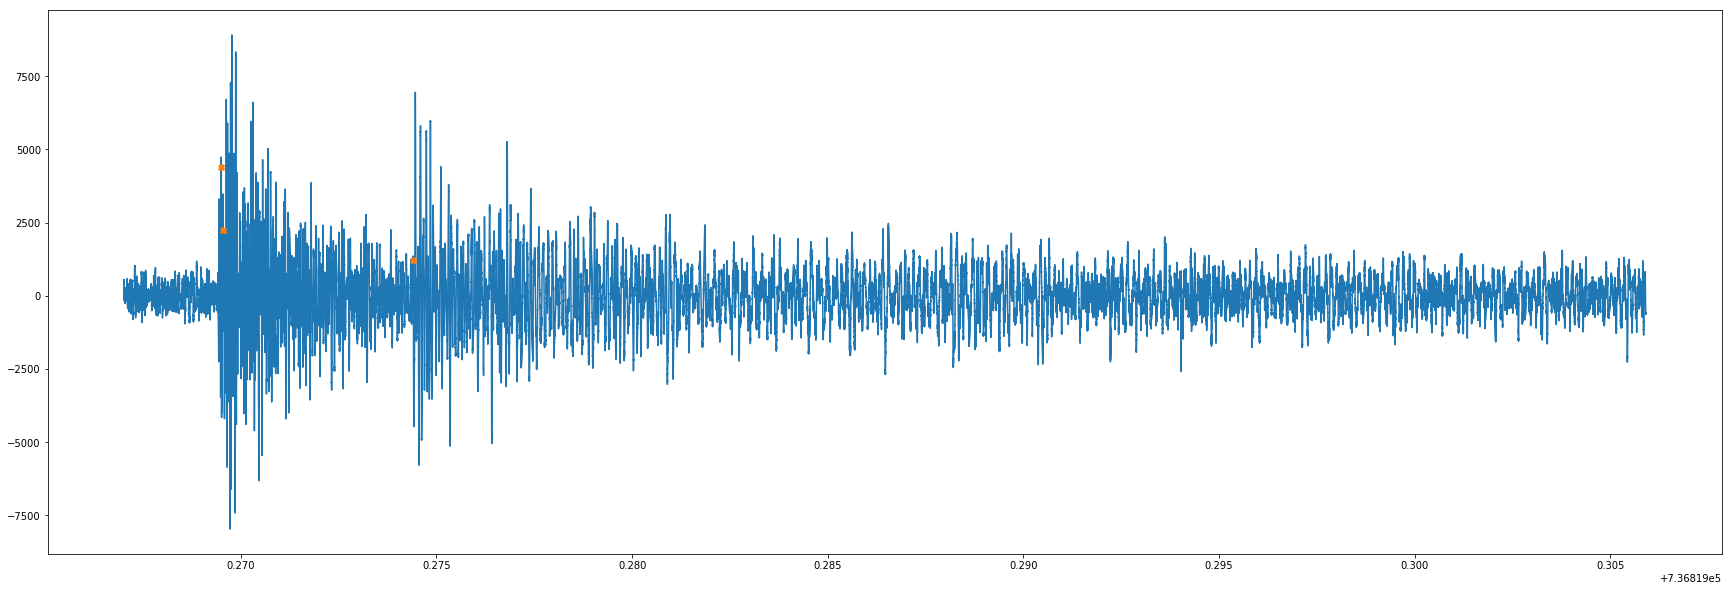

Wall time: 7min 6s


In [24]:
%%time
t1 = station_data[0]
t2 = station_data[1]
t3 = station_data[2]

t1_data = t1.data
t2_data = t2.data
t3_data = t3.data

t1_times = t1.times("utcdatetime")

starttime=UTCDateTime('2018-05-05T06:24:30')
endtime=UTCDateTime('2018-05-05T07:20:30')

ind_s = np.where(t1_times > starttime)
ind_e = np.where(t1_times < endtime)

indexes = np.intersect1d(ind_s, ind_e)
t1_matplotlib_times = t1.times("matplotlib")
t2_matplotlib_times = t2.times("matplotlib")
t3_matplotlib_times = t3.times("matplotlib")

inter = np.intersect1d(lpeaks, indexes)

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1)
ax.plot(t1_matplotlib_times[indexes], t1_data[indexes])
ax.plot(t1_matplotlib_times[inter], t1_data[inter], "X")
plt.show()

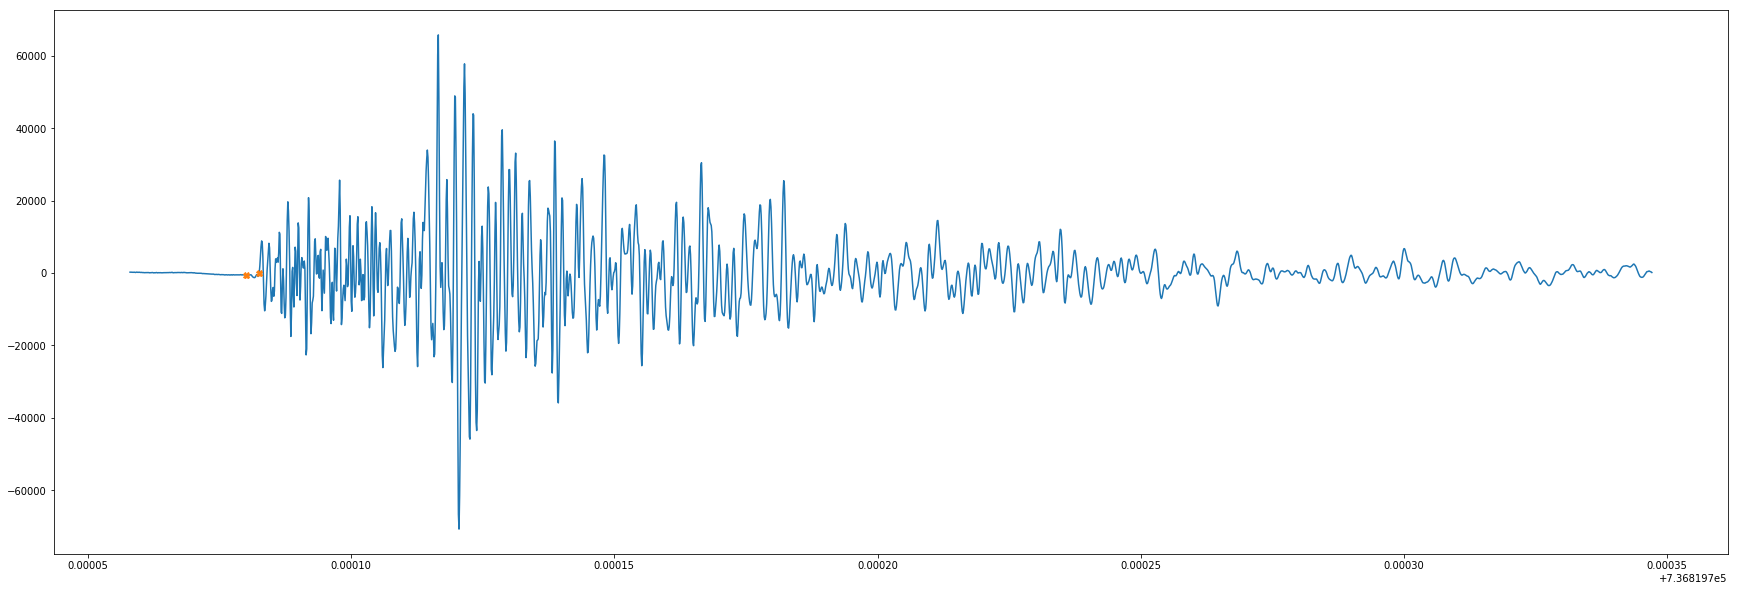

In [27]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1)
ax.plot(t1_matplotlib_times[indexes], t1_data[indexes])
ax.plot(t1_matplotlib_times[inter], t1_data[inter], "X")
plt.show()

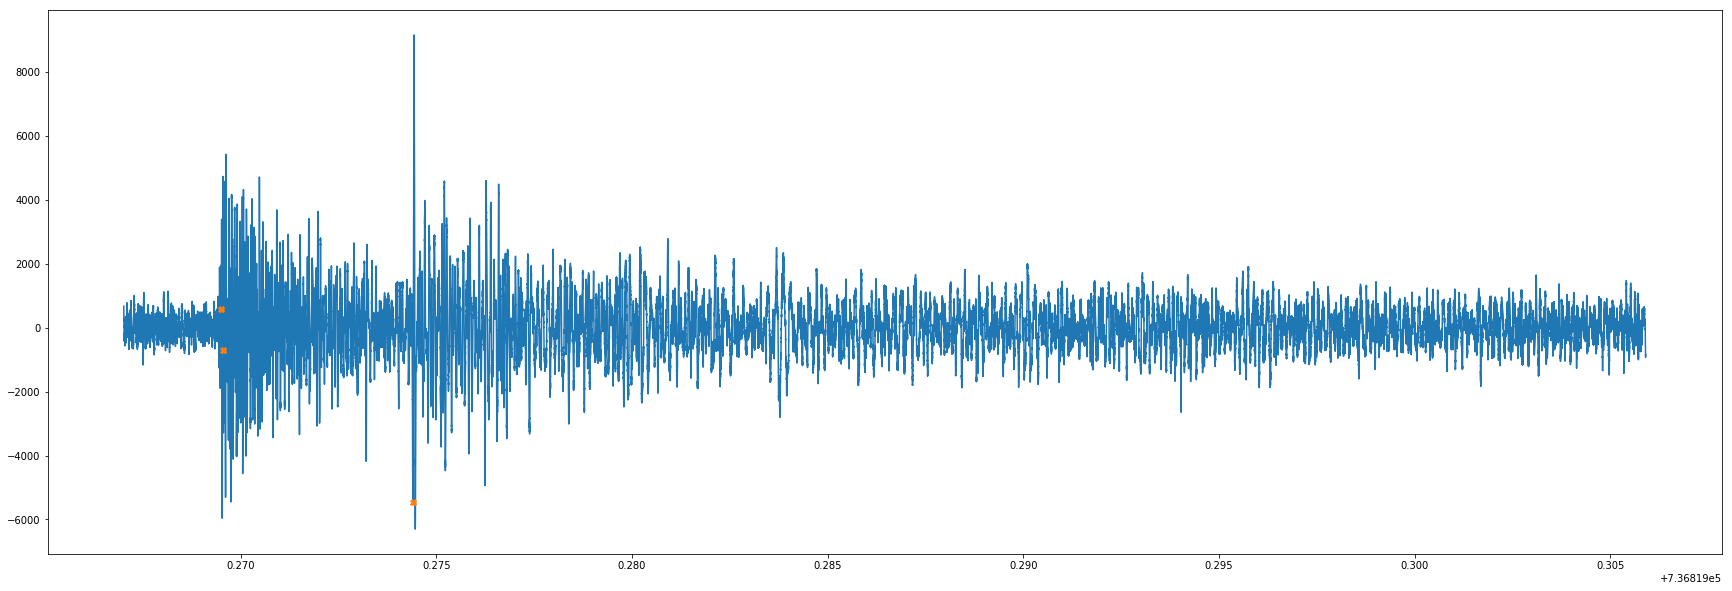

In [25]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1)
ax.plot(t2_matplotlib_times[indexes], t2_data[indexes])
ax.plot(t2_matplotlib_times[inter], t2_data[inter], "X")
plt.show()

In [23]:
fig = plt.figure.Figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1)
ax.plot(t3_matplotlib_times[indexes], t3_data[indexes])
ax.plot(t3_matplotlib_times[inter], t3_data[inter], "X")
plt.pyplot.show()

NameError: name 't3_matplotlib_times' is not defined